##Image data preprocess

**mount to google drive, and unzip dataproject.zip to file in drive, delete files with no data**

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import os
import pickle
import random
import shutil
import time

from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataproject_path="/content/drive/MyDrive/DataScienceProject"
bookcover_folder=os.path.join(dataproject_path, "data")
unzip -q $"/content/drive/MyDrive/DataScienceProject/dataproject.zip" -d $"/content/drive/MyDrive/DataScienceProject"

In [ ]:
for i in os.listdir(bookcover_folder):
  path=os.path.join(bookcover_folder, i)
  if not os.listdir(path):
    os.rmdir(path)

**Delete broken images**

In [ ]:
import imghdr
count=0
for i in os.listdir(bookcover_folder):
  path=os.path.join(bookcover_folder, i)
  for n in os.listdir(path):
    image_path=os.path.join(path, n)
    size = imghdr.what(image_path)
    if size==None:
      os.remove(image_path)
      count=count+1
print("Total broken images:",count)

In [ ]:
count1=0
for i in os.listdir(bookcover_folder):
  path=os.path.join(bookcover_folder, i)
  if len(os.listdir(path))<=200:
    #os.remove(path)
    count1=count1+1
print(count1)

53


##Image clissification

**Create train, validation and test dataset**

In [126]:
bookcover_folder=os.path.join(dataproject_path, "data")
train_set=tf.keras.preprocessing.image_dataset_from_directory(bookcover_folder,label_mode='int',
                                                             image_size=(299,299),
                                                             seed=0,subset='training',
                                                             validation_split=0.2,
                                                              batch_size=32)

val_set=tf.keras.preprocessing.image_dataset_from_directory(bookcover_folder,label_mode='int',
                                                             image_size=(299,299),
                                                             seed=0,subset='validation',
                                                             validation_split=0.2,
                                                            batch_size=32)

test_set=tf.keras.preprocessing.image_dataset_from_directory(bookcover_folder,label_mode='int',
                                                             image_size=(299,299),
                                                             seed=1,subset='validation',
                                                             validation_split=0.2,
                                                             batch_size=32)
#val_set and test_set may have some overlap

Found 13636 files belonging to 75 classes.
Using 10909 files for training.
Found 13636 files belonging to 75 classes.
Using 2727 files for validation.
Found 13636 files belonging to 75 classes.
Using 2727 files for validation.


**Create label dictionary**

In [127]:
booklabel={}
booklabel_inv={}
for i, label in enumerate(train_set.class_names):
  booklabel.update({i:label})
  booklabel_inv.update({label:i})

**Data augmentation**

Since words are always on book cover, neral networks tend to remember those words instead of learning the feature of the book cover images, data augmentation is used to avoid this.

In [3]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.utils import plot_model

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])


AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.map(lambda x, y: (rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
val_set = val_set.map(lambda x, y: (rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
test_set = test_set.map(lambda x, y: (rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

**Cache and prefetch dataset to accelerate input pipeline**

In [8]:
train_set=train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set=val_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set=test_set.cache().prefetch(buffer_size=AUTOTUNE)

**Try a small model**

In [9]:
IMG_SHAPE=(299,299,3)
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=IMG_SHAPE))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(75, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

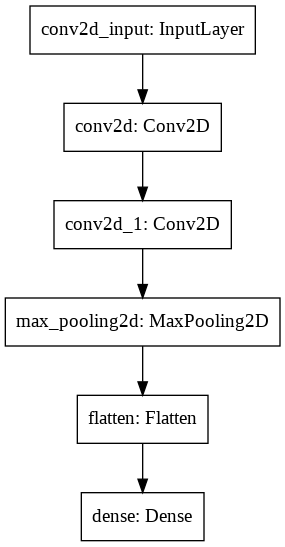

In [14]:
plot_model(model, to_file='model.png')

In [13]:
history=model.fit(train_set, validation_data=val_set, epochs=1)

341/341 [==============================] - 2947s 9s/step - loss: 4.3053 - accuracy: 0.0637 - val_loss: 3.8140 - val_accuracy: 0.0656


**Use transfer learning for image classification**

Here I use InceptionV3 model, and weights trained on imagenet. I add one golbalaveragepooling layer for flatenning and two dense layers at the top for classification.

In [15]:
IMG_SHAPE=(299,299,3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  layers.Flatten(),
  layers.Dense(10, activation='relu'),
  layers.Dense(75, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


**Visualize the model**

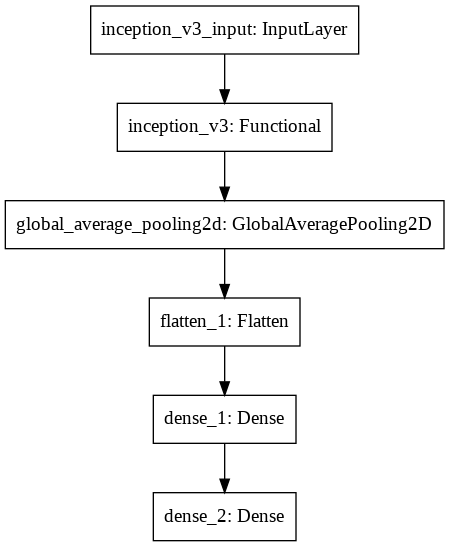

In [67]:
plot_model(model, to_file='model.png')

**Train the model on our train dataset, and save the weights after each train epoch**

In [35]:
checkpoint_dir="/content/drive/MyDrive/DataScienceProject/imagemodel_checkpoints"
os.mkdir(checkpoint_dir)

In [39]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found.")

Loading weights from /content/drive/MyDrive/DataScienceProject/imagemodel_checkpoints/imagecheckpoint


In [40]:
for i in range(1):
  history=model.fit(train_set, validation_data=val_set, epochs=1)
  model.save_weights(os.path.join(checkpoint_dir,"imagecheckpoint"))

341/341 [==============================] - 1353s 4s/step - loss: 3.0400 - accuracy: 0.1956 - val_loss: 3.2544 - val_accuracy: 0.1654


In [42]:
loss, accuracy = model.evaluate(test_set)
print("Accuracy: {:2.2%}".format(accuracy))

86/86 [==============================] - 273s 3s/step - loss: 3.2077 - accuracy: 0.1635
Accuracy: 16.35%


**Export model for raw input**

In [45]:
export_model = tf.keras.Sequential(
    [model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])


**Save the trained model**

In [46]:
modelsave_path=os.path.join(dataproject_path, "imagemodelsave")
os.mkdir(modelsave_path)
export_model.save(modelsave_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DataScienceProject/imagemodelsave/assets


**Load the trained model**

In [68]:
modelsave_path=os.path.join(dataproject_path, "imagemodelsave")
image_model = tf.keras.models.load_model(modelsave_path)

**How to use model **

In [69]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [299,299])
  img /= 255.0  
  return img

def book_cover_predict(image_path):
  image=load_and_preprocess_image(image_path)
  im_batch = tf.expand_dims(image, axis=0)
  prediction = image_model.predict(im_batch)
  mostpossible=np.argsort(prediction)[0][0:3]
  print("Most possible category:")
  for i in mostpossible:
    print(booklabel[i])
  return mostpossible

In [70]:
image_path="/content/drive/MyDrive/DataScienceProject/data/Adventure/0b80c1554f4874fdffdd7a4190aa7f77e32742ce.jpg"

image_result=book_cover_predict(image_path)

Most possible category:
Business
Comics (nonfictional)
Classics


##Book abstract classification

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import csv
from tensorflow.keras.utils import plot_model
booklabel_inv.update({"Sex & Relationships ":75})

**Preprocess data, make label of abstract consistent with label of images**

In [100]:
data_engonly=os.path.join(dataproject_path, "data_engonly.csv")
with open(data_engonly) as myfile:
  data = csv.reader(myfile, delimiter=',')
  data=list(data)
  for info in data:
    if info[0]=="Children’s books":
      info[0]="Children's Books"
    if info[0]=="Educational":
      info[0]="Education & Study Guides"
    info[0]=booklabel_inv[info[0]]
for i in range(5):
  print(data[i])


[0, 'The Jo Modeen Box Set: Books 1 to 3', 'Frank H Jordan', "Josephine Modeen: Beautiful. Noble. Deadly.When contacted by her old CO, she knows it’s not a social call. What she doesn’t know is how it will change her life….The first book in this set of 3 introduces ex-Special Forces soldier Jo Modeen. The next two prove why she's the kick-butt heroine we’d all like to have on our side. Click the BUY button to begin the action-packed adventure today.", 'https://dwtr67e3ikfml.cloudfront.net/bookCovers/5d821fa9936d4b47ac86d4fbad23f128fb068536__300x0']
[0, 'The Jo Modeen Box Set: Books 4 to 6', 'Frank H Jordan', 'The JO MODEEN series: a crimefest of menacing missions and pump-action suspense.In this boxed set of books 4 to 6 in the series, Modeen’s missions uncover dangerous links to the past. Driven to go rogue, she embarks on a lethal campaign of retribution. And even when drawn into an international case that could alter the course of modern warfare, she maintains her mantra: go hard or

**Split data into train, validation and test**

In [101]:
from sklearn.model_selection import train_test_split

random.shuffle(data)
train_info, test_info = train_test_split(data,test_size=0.2)

random.shuffle(data)
train_info, validation_info = train_test_split(data,test_size=0.2) 

label_train = [i[0] for i in train_info]
abstract_train =[i[3] for i in train_info]
label_val = [i[0] for i in validation_info] 
abstract_val = [i[3] for i in validation_info]
label_test = [i[0] for i in test_info]
abstract_test = [i[3] for i in test_info]
#May have overlap

**Define a funtion to create raw dataset from data**

In [102]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def create_dataset(abstract,label):
  dataset = tf.data.Dataset.from_tensor_slices((abstract,label))
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [123]:
raw_train=create_dataset(abstract_train,label_train)
raw_val=create_dataset(abstract_val,label_val)
raw_test=create_dataset(abstract_test,label_test)

**Use vectorize_layer to preprocess raw dataset**

In [130]:
VOCAB_SIZE = 10000
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int')
train_text = raw_train.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [131]:
train_ds = raw_train.map(vectorize_text).cache()
val_ds = raw_val.map(vectorize_text).cache()
test_ds = raw_test.map(vectorize_text).cache()

In [ ]:
# vocab = vectorize_layer.get_vocabulary()
# print(vocab)

**Define a model(small model)**

In [144]:
model = tf.keras.Sequential([
    layers.Embedding(VOCAB_SIZE, 64, mask_zero=True),
    layers.Conv1D(256, 5, padding="valid", activation="relu", strides=1),
    layers.GlobalMaxPooling1D(),
    layers.Dense(76)
])

model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

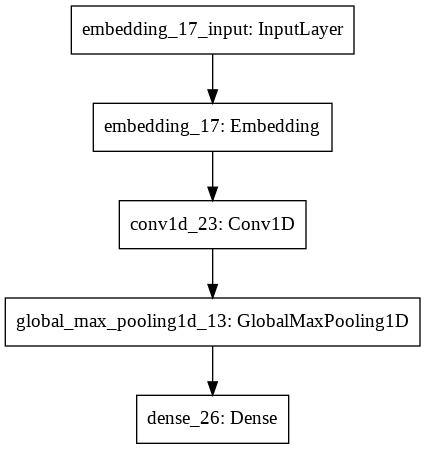

In [178]:
plot_model(model, to_file='model.png')

**Train the model, and evaluate on test dataset**

In [146]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
431/431 [==============================] - 9s 21ms/step - loss: 1.0746 - accuracy: 0.7016 - val_loss: 2.9423 - val_accuracy: 0.2833
Epoch 2/5
431/431 [==============================] - 9s 22ms/step - loss: 0.7931 - accuracy: 0.7694 - val_loss: 3.1539 - val_accuracy: 0.2798
Epoch 3/5
431/431 [==============================] - 9s 21ms/step - loss: 0.6199 - accuracy: 0.8028 - val_loss: 3.3546 - val_accuracy: 0.2705
Epoch 4/5
431/431 [==============================] - 9s 21ms/step - loss: 0.5230 - accuracy: 0.8193 - val_loss: 3.5171 - val_accuracy: 0.2673
Epoch 5/5
431/431 [==============================] - 9s 21ms/step - loss: 0.4704 - accuracy: 0.8278 - val_loss: 3.6288 - val_accuracy: 0.2679


In [147]:
model.evaluate(test_ds)

108/108 [==============================] - 1s 6ms/step - loss: 1.0477 - accuracy: 0.7722


[1.0476654767990112, 0.7722254395484924]

**Export model for raw input**

In [148]:
export_model = tf.keras.Sequential(
    [vectorize_layer,
     model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])


loss, accuracy = export_model.evaluate(raw_test)
print("Accuracy: {:2.2%}".format(accuracy))

108/108 [==============================] - 1s 6ms/step - loss: 2.2063 - accuracy: 0.7719
Accuracy: 77.19%


**Save the trained model**

In [149]:
modelsave_path=os.path.join(dataproject_path, "abstractmodelsave")
os.mkdir(modelsave_path)
export_model.save(modelsave_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DataScienceProject/abstractmodelsave/assets


In [150]:
modelsave_path=os.path.join(dataproject_path, "abstractmodelsave")
abstract_model = tf.keras.models.load_model(modelsave_path)

**How to use model to predict **

In [176]:
def abstract_predict(bookabstract):
  pred=abstract_model.predict(bookabstract)[0]
  mostpossible=np.argsort(np.array(pred))[0:3]
  print("Most possible category:")
  for i in mostpossible:
    print(booklabel[i])
  return mostpossible

In [177]:
#The input bookabstract
bookabstract=["The JO MODEEN series: a crimefest of menacing missions and pump-action suspense.In this boxed set of books 4 to 6 in the series, Modeen’s missions uncover dangerous links to the past. Driven to go rogue, she embarks on a lethal campaign"]
possible_abstarct_category=abstract_predict(bookabstract)

Most possible category:
Weddings
Engineering, trades, & technology
Comics (nonfictional)


## Review evaluation

**Preprocess review data**

Delete review only has star evaluation, which is useless for our model training

In [11]:
data_review=os.path.join(dataproject_path, "data_review.csv")
with open(data_review) as myfile:
  data = csv.reader(myfile, delimiter=',')
  data=list(data)
  #delete comment smaller than two word
  for i,info in enumerate(data):
    if len(info[2])<2:
      del data[i]####
  for i,info in enumerate(data):
    info[1]=int(info[1])
    # if info[1]=="5":
    #   info[1]=5

#Sanity check
for i in range(10):
  print(data[i])

['The Jo Modeen Box Set: Books 1 to 3', 5, 'I found this trilogy by chance.  I have read the three books and have just now ordered the next trilogy that contains books 4-6.  The heroine is Josephine Modeen, an ex special forces soldier. She is recruited into NatSec in Australia, a national security agency with seemingly unlimited resources.  What follows is a high octane chain of actions that involves Josephine as part of a small team of ex-special forces.  They are sent, wherever someone needs to be rescued or disposed off.  The author displays a good knowledge of weaponry and the machinations of secret services, politics, and combat.  Their boss is also an ex-special forces man, a former Corporal who at 6\'4" cuts an imposing figure.I consider these books represent a good read and they give you a good insight of how certain secret service agencies may carry out their operations.']
['The Jo Modeen Box Set: Books 1 to 3', 5, 'The Jo Modeen 1 - 3: Has a preview of the books, which I app

**Split data into train, validation and test**

Some review do not have star evaluation, I will use these review as test data. But test dataset is not for test, I will use the model trained on trainset and validationset to evaluate review in testset and give it star evaluation, so that all the review will have star evaluation.

In [12]:
from sklearn.model_selection import train_test_split
test_info=[]
for m,info in enumerate(data):
  if info[1]==0:
    test_info.append(info)

#Delete ("no rating")
for i in range(len(test_info)):
  test_info[i][2]=test_info[i][2][11:]

for i in range(5):
  print(test_info[i])

['Pirates of Savannah: The Complete Trilogy (Adult Version) - Historical Fiction Action Adventure', 0, "Pirates of Savannah isn't just a historical fiction novel about the birth of liberty in the south. It is the best example I can find in modern literature of socio-political literature that carries a specific moral tone that isn't preachy or indeed hypocritical about what it is trying to say.I was smacked in the face by the excellence of Tarin's writing style and believe this to be a hyper-real version of Disney's classic tale Pirate's of the Caribbean. I see it as a movie and hope it does get made! 5 stars doesn't do justice to the awesomeness contained herein."]
['Pirates of Savannah: The Complete Trilogy (Adult Version) - Historical Fiction Action Adventure', 0, "Pirates is a well written and moving read. It intrigues one's imagination with descriptive and colorful writing that captivates one's attention.  Not only speaking in the present, but actually brings the past to the presen

In [15]:
for m,info in enumerate(data):
  if info[1]==0:
    del data[m]#delete will mass up index, run this step till bo output occur.
for i in data:
  if i[1]==0:
    print(i)
    break

In [16]:
#change label to 0-4
for i in data:
  i[1]=i[1]-1


random.shuffle(data)
train_info, validation_info = train_test_split(data,test_size=0.2) 

label_train = [i[1] for i in train_info]
review_train =[i[2] for i in train_info]
label_val = [i[1] for i in validation_info] 
review_val = [i[2] for i in validation_info]
label_test = [i[1] for i in test_info]
review_test = [i[2] for i in test_info]

**Define a funtion to create raw dataset from data**

In [17]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def create_dataset(abstract,label):
  dataset = tf.data.Dataset.from_tensor_slices((abstract,label))
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [18]:
raw_train=create_dataset(review_train,label_train)
raw_val=create_dataset(review_val,label_val)
raw_test=create_dataset(review_test,label_test)

**Use vectorize_layer to preprocess raw dataset**

In [19]:
VOCAB_SIZE = 10000
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int')
train_text = raw_train.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [20]:
train_ds = raw_train.map(vectorize_text).cache()
val_ds = raw_val.map(vectorize_text).cache()
test_ds = raw_test.map(vectorize_text).cache()

In [ ]:
# vocab = vectorize_layer.get_vocabulary()
# print(vocab)

**Try a small model**

In [21]:
model = tf.keras.Sequential([
    layers.Embedding(VOCAB_SIZE, 32, mask_zero=True),
    layers.Conv1D(16, 5, padding="valid", activation="relu", strides=1),
    layers.GlobalMaxPooling1D(),
    layers.Dense(5)
])

model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

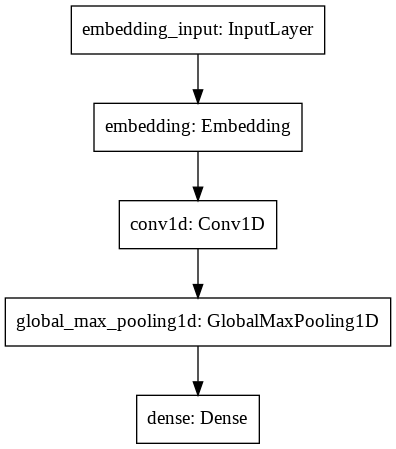

In [22]:
plot_model(model, to_file='model.png')

**Train the model**

In [98]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
136/136 [==============================] - 3s 23ms/step - loss: 1.0406 - accuracy: 0.7035 - val_loss: 0.6345 - val_accuracy: 0.8133
Epoch 2/10
136/136 [==============================] - 3s 22ms/step - loss: 0.6161 - accuracy: 0.8068 - val_loss: 0.6135 - val_accuracy: 0.8133
Epoch 3/10
136/136 [==============================] - 3s 22ms/step - loss: 0.5676 - accuracy: 0.8089 - val_loss: 0.5860 - val_accuracy: 0.8161
Epoch 4/10
136/136 [==============================] - 3s 21ms/step - loss: 0.4866 - accuracy: 0.8343 - val_loss: 0.5548 - val_accuracy: 0.8207
Epoch 5/10
136/136 [==============================] - 3s 21ms/step - loss: 0.3905 - accuracy: 0.8764 - val_loss: 0.5340 - val_accuracy: 0.8235
Epoch 6/10
136/136 [==============================] - 3s 20ms/step - loss: 0.3040 - accuracy: 0.9115 - val_loss: 0.5223 - val_accuracy: 0.8262
Epoch 7/10
136/136 [==============================] - 3s 21ms/step - loss: 0.2335 - accuracy: 0.9314 - val_loss: 0.5196 - val_accuracy: 0.8272

**Hyperparameter tuning**

From the training result above, we can see that the accuracay is good, but it's overfit. For review evaluation, I hope my model can be as accurate as possible, both on trainset and validationset. Therefore, here I use Hyperparameter tuning to find best parameters for my model, and to increase the accuracy.

**Reference:**

[1] Tensorflow tutorial: Hyperparameter tuning

[2] Hyperparameter tuning with Keras Tuner — The TensorFlow Blog


In [89]:
from tensorflow import keras
import IPython

!pip install -q -U keras-tuner
import kerastuner as kt
import tensorflow_datasets as tfds

     |████████████████████████████████| 71kB 3.1MB/s 


In [90]:
def model_builder(hp):
  model = keras.Sequential()

  hp_output_dim = hp.Int('output_dim', min_value = 32, max_value = 128, step = 32)
  model.add(keras.layers.Embedding(VOCAB_SIZE+1, output_dim=hp_output_dim, mask_zero=True))

  hp_filters = hp.Int('filters', min_value = 32, max_value = 128, step = 32)
  model.add(keras.layers.Conv1D(filters=hp_filters, kernel_size=5, padding="valid", activation="relu", strides=1))
  
  model.add(keras.layers.GlobalMaxPooling1D())
  model.add(keras.layers.Dense(5))
  

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                metrics = ['accuracy'])

  return model

In [91]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'kt',
                     overwrite = True) 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)                      

In [93]:
tuner.search(train_ds, epochs = 5, validation_data = val_ds, callbacks = [ClearTrainingOutput()])


best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]


Trial 30 Complete [00h 01m 30s]
val_accuracy: 0.8447319865226746

Best val_accuracy So Far: 0.8539741039276123
Total elapsed time: 00h 19m 13s
INFO:tensorflow:Oracle triggered exit


In [94]:
print(f"""
The hyperparameter search is complete. The optimal number of output_dim in the first Embedding
layer is {best_hps.get('output_dim')},The optimal number of filters in the second Conv1D
layer is {best_hps.get('filters')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of output_dim in the first Embedding
layer is 128,The optimal number of filters in the second Conv1D
layer is 64 and the optimal learning rate for the optimizer
is 0.001.



In [99]:
model = tuner.hypermodel.build(best_hps)
model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
136/136 [==============================] - 12s 88ms/step - loss: 0.7517 - accuracy: 0.7804 - val_loss: 0.6102 - val_accuracy: 0.8133
Epoch 2/10
136/136 [==============================] - 12s 86ms/step - loss: 0.5612 - accuracy: 0.8110 - val_loss: 0.5453 - val_accuracy: 0.8170
Epoch 3/10
136/136 [==============================] - 12s 87ms/step - loss: 0.4229 - accuracy: 0.8500 - val_loss: 0.4872 - val_accuracy: 0.8309
Epoch 4/10
136/136 [==============================] - 12s 87ms/step - loss: 0.2650 - accuracy: 0.9187 - val_loss: 0.4625 - val_accuracy: 0.8373
Epoch 5/10
136/136 [==============================] - 12s 88ms/step - loss: 0.1458 - accuracy: 0.9612 - val_loss: 0.4645 - val_accuracy: 0.8420
Epoch 6/10
136/136 [==============================] - 12s 89ms/step - loss: 0.0795 - accuracy: 0.9836 - val_loss: 0.4983 - val_accuracy: 0.8438
Epoch 7/10
136/136 [==============================] - 12s 92ms/step - loss: 0.0479 - accuracy: 0.9912 - val_loss: 0.5359 - val_accuracy:

**Export model for raw input**

In [ ]:
export_model = tf.keras.Sequential(
    [vectorize_layer,
     model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])


**Save the trained model**

In [102]:
modelsave_path=os.path.join(dataproject_path, "reviewmodelsave")
os.mkdir(modelsave_path)
export_model.save(modelsave_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DataScienceProject/reviewmodelsave/assets


**Load the saved model**

In [8]:
modelsave_path=os.path.join(dataproject_path, "reviewmodelsave")
review_model = tf.keras.models.load_model(modelsave_path)

**Use model to rate book review with no star evaluation**

**How to use **

In [9]:
def review_prediction(bookreview):
  pred=review_model.predict(bookreview)[0]
  star=np.argmax(pred)+1
  print("Predicted star rank:", star)
  return star

In [10]:
#The input bookreview
bookreview=["another great adventure with Ben Hood, just like catching up with an old mate.Thanks Drew Lindsay for another ripping tail to fully immerse myself into."]
star_rank=review_prediction(bookreview)

Predicted star rank: 5


## Book recommendation system(Data preprocess)

****Process  all the data needed in recommendation system** 

**Now use the model to predict star rank of review that not rated**

In [104]:
data_review=os.path.join(dataproject_path, "data_review.csv")
with open(data_review) as myfile:
  review_data = csv.reader(myfile, delimiter=',')
  review_data=list(review_data)

for i in review_data:
  if i[1]==0:
    i[2]=i[2][11:]

for review in review_data:
  if review[1]==0:
    star_rank=review_prediction(review[2])
    review[1]=star_rank

#Sanity check
for i in review_data:
  if i[1]==0:
    print(i)
    break
print("all no rating book review are now rated")

all no rating book review are now rated


**Delete books that have low star rank**

In [105]:
rank=[]
new_book_rank=[]
for number,detail in enumerate(review_data):
  bookname=detail[0]
  rank.append(int(detail[1]))
  break
meanrank=np.mean(rank)
for number,detail in enumerate(review_data):
  if bookname!=detail[0]:
    meanrank=np.mean(rank)
    rank=[]
    bookmean=[bookname,meanrank]
    new_book_rank.append(bookmean)

    bookname=detail[0]
  if bookname==detail[0]:
    bookname=detail[0]
    rank.append(int(detail[1]))

for n,i in enumerate(new_book_rank):
  if i[1]<3:
    del new_book_rank[n]


In [106]:
#sanity check
for i in range(5):
  print(new_book_rank[i])

['The Jo Modeen Box Set: Books 1 to 3', 5.0]
['The Jo Modeen Box Set: Books 4 to 6', 5.0]
['Spinward Fringe Broadcast 12: Invasion', 5.0]
['Dead Soul (In Her Name, Book 3)', 4.666666666666667]
['Black Lagoon', 5.0]


**Add book cover image path at the end for later convinience**

In [107]:
data_engonly=os.path.join(dataproject_path, "data_engonly.csv")
with open(data_engonly) as myfile:
  data = csv.reader(myfile, delimiter=',')
  data=list(data)

for i,n in enumerate(new_book_rank):
  for nn in data:
    if n[0]==nn[1]:
      new_book_rank[i].append(nn[0])
      new_book_rank[i].append(nn[4])
      break


In [108]:
for i,n in enumerate(new_book_rank):
  if len(new_book_rank[i])!=4:
    del new_book_rank[i]

for i,n in enumerate(new_book_rank):
  new_book_rank[i][3]=n[3].split("/")[-1]
  new_book_rank[i][3]=dataproject_path+'/data/'+new_book_rank[i][2]+'/'+new_book_rank[i][3][:-7]+'.jpg'

In [121]:
co=0
for n,i in enumerate(new_book_rank):
  if os.path.exists(i[3])==False:
    del new_book_rank[n]
    co=co+1
#print(co)
print("The number of highly recommended good books:")
print(len(new_book_rank))

The number of highly recommended good books:
574


In [119]:
#sanity check
for i in range(5):
  print(new_book_rank[i])

['The Jo Modeen Box Set: Books 1 to 3', 5.0, 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/5d821fa9936d4b47ac86d4fbad23f128fb068536.jpg']
['The Jo Modeen Box Set: Books 4 to 6', 5.0, 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/16bdafe0e68eed42f2064dec9810836e206c2184.jpg']
['Spinward Fringe Broadcast 12: Invasion', 5.0, 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/9b8d9026a6b63929dd7eb1c99c403ab2e888179a.jpg']
['Dead Soul (In Her Name, Book 3)', 4.666666666666667, 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/56fc5a07ddc29526bc651988a437cd8c2439a194.jpg']
['Black Lagoon', 5.0, 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/ded061c728049266a51fbc5a7ad48cec26f0ee18.jpg']


**Svae data in csv file**

In [120]:
import pandas as pd

savecsv=pd.DataFrame(data=new_book_rank)
#print(savecsv)
newreview_path=os.path.join(dataproject_path, "new_review.csv")
savecsv.to_csv(newreview_path)

**Now we have a csv file containing all the data we need, in the next step, we will build a book recommendation system**

## Build recommendation system

**Load trained image model and abstract model**

In [206]:
print("Loading Models .......")
modelsave_path=os.path.join(dataproject_path, "abstractmodelsave")
abstract_model = tf.keras.models.load_model(modelsave_path)

def abstract_predict(bookabstract):
  pred=abstract_model.predict(bookabstract)[0]
  mostpossible=np.argsort(np.array(pred))[0:3]
  # print("Most possible category:")
  # for i in mostpossible:
  #   print(booklabel[i])
  return mostpossible

modelsave_path=os.path.join(dataproject_path, "imagemodelsave")
image_model = tf.keras.models.load_model(modelsave_path)  

def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [299,299])
  img /= 255.0  
  return img

def book_cover_predict(image_path):
  image=load_and_preprocess_image(image_path)
  im_batch = tf.expand_dims(image, axis=0)
  prediction = image_model.predict(im_batch)
  mostpossible=np.argsort(prediction)[0][0:3]
  # print("Most possible category:")
  # for i in mostpossible:
  #   print(booklabel[i])
  return mostpossible
print("Done")

Loading Models .......
Done


**Load new review csv file**

In [207]:
newreview_path=os.path.join(dataproject_path, "new_review.csv")
with open(newreview_path) as myfile:
  newreview= csv.reader(myfile, delimiter=',')
  newreview=list(newreview)
#Sanity check
for i in range(6):
  print(newreview[i])

['', '0', '1', '2', '3']
['0', 'The Jo Modeen Box Set: Books 1 to 3', '5.0', 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/5d821fa9936d4b47ac86d4fbad23f128fb068536.jpg']
['1', 'The Jo Modeen Box Set: Books 4 to 6', '5.0', 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/16bdafe0e68eed42f2064dec9810836e206c2184.jpg']
['2', 'Spinward Fringe Broadcast 12: Invasion', '5.0', 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/9b8d9026a6b63929dd7eb1c99c403ab2e888179a.jpg']
['3', 'Dead Soul (In Her Name, Book 3)', '4.666666666666667', 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/56fc5a07ddc29526bc651988a437cd8c2439a194.jpg']
['4', 'Black Lagoon', '5.0', 'Adventure', '/content/drive/MyDrive/DataScienceProject/data/Adventure/ded061c728049266a51fbc5a7ad48cec26f0ee18.jpg']


**Define recommendation system function**

In [208]:
def book_recommendation(image_path,bookabstract):
  image_result=book_cover_predict(image_path)
  abstarct_result=abstract_predict(bookabstract)

  samepredict=[a for a in image_result if a in abstarct_result]
  allpredict=list(image_result)+list(abstarct_result)
  for i in samepredict:
    for m,n in enumerate(allpredict):
      if i==n:
        del allpredict[m]
        break
  random.shuffle(newreview)

  for i in allpredict:
    ms=0
    ll=len(allpredict)
    #print(booklabel[i])
    plt.figure(figsize=(22,22))
    for n in newreview:
      if booklabel[i]==n[3]:
        plt.subplot(ll,3,ms+1)
        pic=plt.imread(n[4])
        plt.imshow(pic)
        plt.xlabel("({} {:2.3})".format('Star rank:',n[2]))
        ms=ms+1
      if ms==3:
        break

**How to use **

Input image path and book abstract, the book recommendation function will give back books related and recommended with star rank under the book cover images.

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

<Figure size 1584x1584 with 0 Axes>

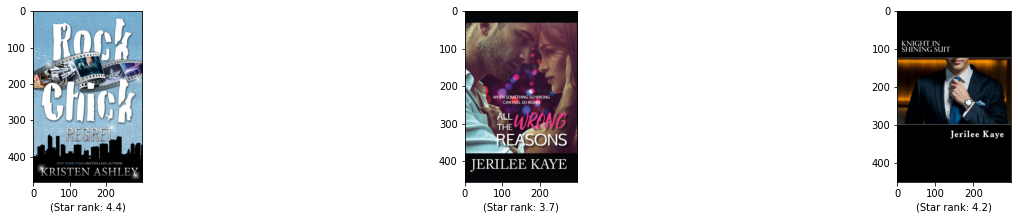

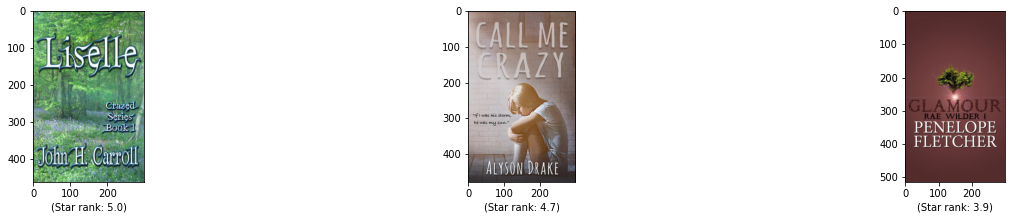

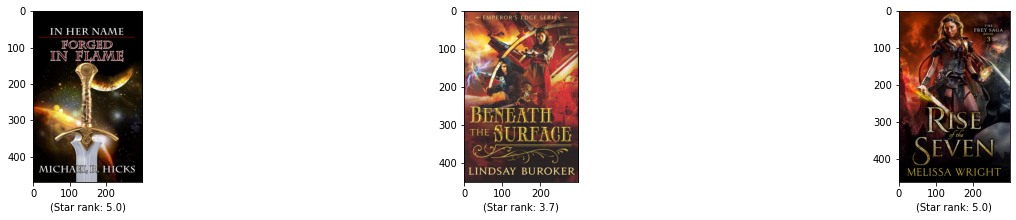

In [210]:
image_path="/content/drive/MyDrive/DataScienceProject/data/True Crime/04fff87dfa1b0cabc124ca2af098d2625bbbc80f.jpg"
bookabstract=["The Story of Fred and Rosemary West examines the horrifying account of an incestuous butcher and his wife, a bisexual nymphomaniac who kept their deadly secrets buried in their garden at 25 Cromwell Street."]

book_recommendation(image_path,bookabstract)